In [920]:
import pandas as pd
import numpy as np
from malbecs.preprocess import wine
import seaborn as sns

In [840]:
path = '../../data/raw/UH_2023_TRAIN.txt'

In [841]:
wine_data = wine.load_wine_dataset(path)
wine_data = wine.norm_columns(wine_data)
wine_data = wine.process_altitud(wine_data)
wine_data = wine.replace_zeros_with_na(wine_data, cols=['superficie','altitud'])
wine_data = wine.fillna_by_group(wine_data, cols=['altitud'], group=['id_estacion'])


In [842]:
wine_data.isnull().sum()

campana           0
id_finca          0
id_zona           0
id_estacion       0
altitud           0
variedad          0
modo              0
tipo              0
color             0
superficie     6518
produccion     1075
dtype: int64

## Modelo de Superficie

In [843]:
# problem 1: predict/estimate missing surfaces
data = wine_data[wine_data['campana']<22]

In [844]:
# data for surface estimation
data_surface = data[data['superficie'].notnull()] 

In [845]:
X = data_surface.drop(columns=['superficie'])
y = data_surface['superficie']

train_idxs, test_idxs = X[X['campana'] < 21].index, X[X['campana'] == 21].index

cat_cols = [
    'id_estacion',
    'id_zona',
    'variedad',
    'modo',
    'color'
]
num_cols = [
    'produccion',
    'altitud'
]

X = X[cat_cols+num_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, X_test, y_train, y_test = X.loc[train_idxs],X.loc[test_idxs], y.loc[train_idxs], y.loc[test_idxs]

In [846]:
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import category_encoders as ce
import catboost as cb

seed = 42

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def score_preds(y_true, y_pred):
    return {
        "mape":mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred),
        "rmse": rmse_score(y_true=y_true, y_pred=y_pred)
    }


def create_errors_dataframe(X_test, y_test, y_pred):
    errors = pd.DataFrame(y_test)
    errors.columns = ['y_true']
    errors['y_pred'] = y_pred
    errors['err'] = np.abs(errors['y_pred'] - errors['y_true'])
    errors = pd.concat([X_test, errors], axis=1)
    errors = errors.sort_values('err', ascending=False)
    return errors


In [908]:
from sklearn.preprocessing import StandardScaler


model = make_pipeline(
    make_column_transformer(
        (ce.BaseNEncoder(base=2),['variedad']),
        # (ce.CountEncoder(min_group_size=50),['variedad']),
        (ce.CountEncoder(min_group_size=30), ['id_zona']),
        (ce.OneHotEncoder(), ['id_estacion']),
        (ce.OneHotEncoder(),['modo','color']),
        # (ce.TargetEncoder(),cat_cols),
        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat_cols),
        (StandardScaler(), num_cols)
    ),
    # RandomForestRegressor(max_features=0.5, n_estimators=300, random_state=seed)
    RandomForestRegressor(max_features='sqrt',criterion='poisson',n_estimators=800, random_state=seed)
)
y_pred = model.fit(X_train, y_train).predict(X_test)

score_preds(y_test, y_pred)

{'mape': 0.651062588460983, 'rmse': 1.2084959006426246}

In [909]:
errors = create_errors_dataframe(X_test, y_test, y_pred)

<Axes: >

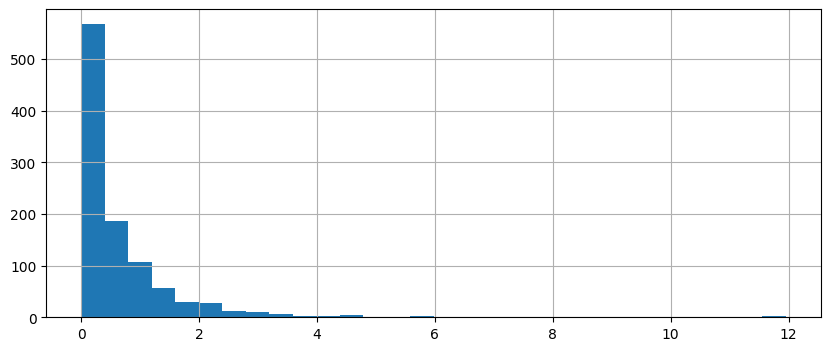

In [910]:
errors['err'].hist(bins=30, figsize=(10,4))

In [911]:
errors.groupby('variedad').agg(
    mean_err=('err','mean'), 
    count_var=('err','count'),
    max_err=('err','max'),
    std_err=('err','std')
    ).sort_values('mean_err',ascending=False)

,mean_err,count_var,max_err,std_err
variedad,,,,
62,3.182213,2,4.523953,1.897508
4,2.265863,6,8.374601,3.140362
48,1.834735,1,1.834735,NaN
81,0.850383,64,4.940379,0.968180
59,0.832980,255,11.954096,1.459470
10,0.773263,1,0.773263,NaN
9,0.754175,42,4.675471,0.924353
26,0.743691,32,2.998342,0.918866
43,0.693422,9,2.496095,0.808585


In [912]:
# ce.BaseNEncoder(base=2).fit_transform(X[['variedad']])
# ce.HashingEncoder().fit_transform(X[['variedad']])
# ce.SumEncoder().fit_transform(X[['variedad']],y)
# ce.CountEncoder(min_group_size=30).fit_transform(X[['id_zona']]).value_counts()
# X[['variedad']]

In [913]:
model_surface = model.fit(X, y)


## Modelo de Producion

In [1107]:
# usamos desde 15 en adelante
data_prod = data[data['campana']>16].copy()

# imputamos superficie.
data_prod['superficie_real'] = data_prod['superficie'].notnull().astype('category')
X_surface = data_prod[data_prod['superficie'].isnull()]
pred_surface = model_surface.predict(X_surface)

data_prod.loc[data_prod['superficie'].isnull(), 'superficie']  = pred_surface


In [1108]:
# sns.histplot(
#     data_prod,
#     x='superficie',
#     hue='superficie_real'
# )

In [1109]:

prod_he_var_year = []
prod_he_var_historic = []
prod_he_var_tot_year = []
prod_he_var_tot_historic = []

for i in range(18,22):
    prod_he_var_year.append(
        (
            data_prod
            [['campana', 'variedad', 'modo', 'id_zona', 'superficie', 'produccion']]
            .assign(prod_he=lambda df: df['produccion']/df['superficie'])
            .query('prod_he>0')
            [['campana', 'id_zona', 'variedad', 'modo', 'prod_he']]
            .query('campana==@i-1')
            .groupby(['variedad', 'modo', 'id_zona',])
            .agg(
                prod_he_mean_year=('prod_he', 'mean'),
                prod_he_std_year=('prod_he', 'std')
            )
            .fillna(-1)
            .reset_index()
            .assign(
                campana=i
            )
        )
    )
    prod_he_var_historic.append(
        (
            data_prod
            [['campana', 'variedad', 'modo', 'id_zona', 'superficie', 'produccion']]
            .assign(prod_he=lambda df: df['produccion']/df['superficie'])
            .query('prod_he>0')
            [['campana', 'id_zona', 'variedad', 'modo', 'prod_he']]
            .query('campana<@i')
            .groupby(['variedad', 'modo', 'id_zona',])
            .agg(
                prod_he_mean_hist=('prod_he', 'mean'),
                prod_he_std_hist=('prod_he', 'std')
            )
            .fillna(-1)
            .reset_index()
            .assign(
                campana=i
            )
        )
    )
    prod_he_var_tot_year.append(
        (
            data_prod
            [['campana', 'variedad', 'modo', 'superficie', 'produccion']]
            .assign(prod_he=lambda df: df['produccion']/df['superficie'])
            .query('prod_he>0')
            [['campana', 'variedad', 'modo', 'prod_he']]
            .query('campana==@i-1')
            .groupby(['variedad', 'modo',])
            .agg(
                prod_he_var_mean_year=('prod_he', 'mean'),
                prod_he_var_std_year=('prod_he', 'std')
            )
            .fillna(-1)
            .reset_index()
            .assign(
                campana=i
            )
        )
    )

    prod_he_var_tot_historic.append(
        (
            data_prod
            [['campana', 'variedad', 'modo', 'superficie', 'produccion']]
            .assign(prod_he=lambda df: df['produccion']/df['superficie'])
            .query('prod_he>0')
            [['campana', 'variedad', 'modo', 'prod_he']]
            .query('campana<@i')
            .groupby(['variedad', 'modo',])
            .agg(
                prod_he_var_mean_hist=('prod_he', 'mean'),
                prod_he_var_std_hist=('prod_he', 'std')
            )
            .fillna(-1)
            .reset_index()
            .assign(
                campana=i
            )
        )
    )


In [1110]:
data_prod = data_prod.merge(
    pd.concat(prod_he_var_historic),
    left_on=['variedad','modo','id_zona','campana'],
    right_on=['variedad', 'modo', 'id_zona', 'campana'],
    how='left'
).merge(
    pd.concat(prod_he_var_year),
    left_on=['variedad', 'modo', 'id_zona', 'campana'],
    right_on=['variedad', 'modo', 'id_zona', 'campana'],
    how='left'
).merge(
    pd.concat(prod_he_var_tot_historic),
    left_on=['variedad', 'modo', 'campana'],
    right_on=['variedad', 'modo', 'campana'],
    how='left'
).merge(
    pd.concat(prod_he_var_tot_year),
    left_on=['variedad', 'modo', 'campana'],
    right_on=['variedad', 'modo', 'campana'],
    how='left'
).fillna(-1).fillna(-1)

# pd.concat(prod_he_var_year)


In [1111]:
data_prod.columns

Index(['campana', 'id_finca', 'id_zona', 'id_estacion', 'altitud', 'variedad',
       'modo', 'tipo', 'color', 'superficie', 'produccion', 'superficie_real',
       'prod_he_mean_hist', 'prod_he_std_hist', 'prod_he_mean_year',
       'prod_he_std_year', 'prod_he_var_mean_hist', 'prod_he_var_std_hist',
       'prod_he_var_mean_year', 'prod_he_var_std_year'],
      dtype='object')

In [1113]:
# ahora entrenamos para predecir la produccion de 2021
X = data_prod.drop(columns=['produccion'])
y = data_prod['produccion']

train_idxs, test_idxs = X[X['campana'] < 21].index, X[X['campana'] == 21].index

cat_cols = [
    'id_finca',
    'id_estacion',
    'campana',
    'id_zona',
    'variedad',
    'modo',
    'color',
    'superficie_real'
]

num_cols = [
    'superficie',
    'altitud',
    'prod_he_mean_hist', 
    'prod_he_std_hist', 
    'prod_he_mean_year',
    'prod_he_std_year', 
    'prod_he_var_mean_hist', 
    'prod_he_var_std_hist',
    'prod_he_var_mean_year', 
    'prod_he_var_std_year'
]

X = X[cat_cols+num_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, X_test, y_train, y_test = X.loc[train_idxs],X.loc[test_idxs], y.loc[train_idxs], y.loc[test_idxs]

In [1121]:
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
import xgboost as xgb


model = make_pipeline(
    make_column_transformer(
        # (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca']),

        (ce.BaseNEncoder(base=2), ['variedad']),
        (ce.CountEncoder(min_group_size=20),['variedad']),
        
        (ce.CountEncoder(min_group_size=30), ['id_zona']),
        (ce.BaseNEncoder(base=2), ['id_zona']),

        (ce.OneHotEncoder(), ['modo', 'color', 'superficie_real','id_estacion']),
        
        # (ce.TargetEncoder(), ['modo']),
        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat_cols),

        (KBinsDiscretizer(n_bins=3),['altitud']),

        # (KBinsDiscretizer(n_bins=2), num_cols),
        # (StandardScaler(), ['superficie']),
        (StandardScaler(), num_cols),
    ),
    RandomForestRegressor(n_estimators=500, max_features=0.9, random_state=seed)
    # RandomForestRegressor(n_estimators=500, max_features='sqrt', criterion='poisson', random_state=seed)
)
sample_weight = X_train['campana'].apply(lambda x: 0.1 if x < 20 else 1).values

y_pred = model.fit(
    X_train, y_train, 
    randomforestregressor__sample_weight=sample_weight
).predict(X_test)

score_preds(y_test, y_pred)


{'mape': 1.7112730673259107, 'rmse': 5285.320062588571}

In [1122]:
errors = create_errors_dataframe(X_test, y_test, y_pred)

<Axes: >

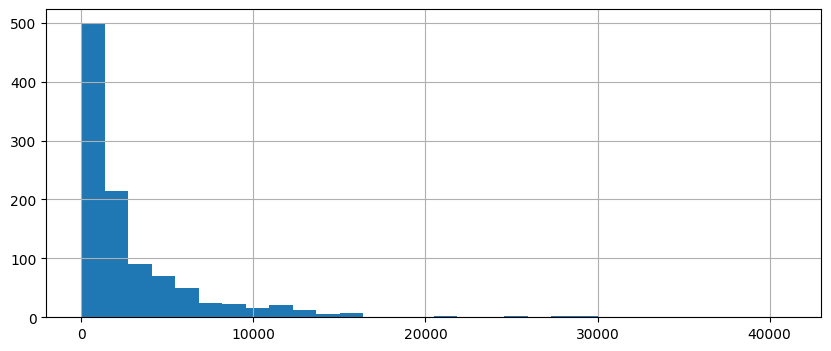

In [1123]:
errors['err'].hist(bins=30, figsize=(10,4))

In [1125]:
errors.groupby('variedad').agg(
    mean_err=('err','mean'), 
    count_var=('err','count'),
    max_err=('err','max'),
    # std_err=('err','std')
    ).sort_values('max_err',ascending=False)

,mean_err,count_var,max_err
variedad,,,
17,2646.552710,166,40943.810904
59,2523.688837,263,35397.493616
32,3811.571455,117,32863.149868
62,16033.436865,2,29055.672538
15,4236.253841,44,29039.748014
87,3292.082185,54,28190.779832
23,3780.774962,17,26863.256610
9,2965.564209,42,24740.845650
81,3911.825922,64,21351.078052


## Modelo Superficie + Weather

In [971]:
eto_data = pd.read_csv('../../data/final/eto_final.csv')
meteo_data = pd.read_csv('../../data/processed/meteo_pro.csv')
eto_data['year'] = eto_data.year % 2000
meteo_data['year'] = meteo_data.year % 2000

In [972]:
eto_cols = eto_data.columns[2:].to_list()

gust_cols = [c for c in eto_cols if "GustLocal" in c]
temp_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
wind_cols = [c for c in eto_cols if "WindSpeedLoca" in c]
mlsp_cols = [c for c in eto_cols if "MSLPLocalDayAvg" in c]
precip_cols = [c for c in eto_cols if "TotalPrecipMonth" in c]
snow_cols = [c for c in eto_cols if "TotalSnowMonth1" in c]
hum_cols = [c for c in eto_cols if "RelativeHumidityLocalDayAvg" in c]

In [973]:
meteo_cols = meteo_data.columns[2:].to_list()

light_cols = [c for c in meteo_cols if "LightHours" in c]
meteo_temp_cols = [c for c in meteo_cols if "temp" in c]

In [974]:
data_surface_full = data_surface.merge(
    meteo_data,
    left_on=['id_estacion', 'campana'],
    right_on=['ID_ESTACION', 'year'],
    how='left'
).merge(
    eto_data,
    left_on=['id_estacion', 'campana'],
    right_on=['ID_ESTACION', 'year'],
    how='left'
)

In [976]:

X = data_surface_full.drop(columns=['superficie'])
y = data_surface_full['superficie']

train_idxs, test_idxs = X[X['campana'] < 21].index, X[X['campana'] == 21].index

cat_cols = [
    'id_estacion',
    'id_zona',
    'variedad',
    'modo',
    'color'
]
num_cols = [
    'produccion',
    'altitud'
]

X = X[cat_cols+num_cols+meteo_cols+eto_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, X_test, y_train, y_test = X.loc[train_idxs],X.loc[test_idxs], y.loc[train_idxs], y.loc[test_idxs]

In [983]:
# from math import remainder
import catboost as cb
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler


model = make_pipeline(
    make_column_transformer(
        (ce.BaseNEncoder(base=2), ['variedad']),
        (ce.CountEncoder(min_group_size=30), ['id_zona']),
        (ce.OneHotEncoder(), ['id_estacion']),
        (ce.OneHotEncoder(), ['modo', 'color']),
        (StandardScaler(), num_cols),

        (KBinsDiscretizer(n_bins=4), ['altitud']),
        # (KBinsDiscretizer(n_bins=4), ['produccion']),
        
        # (make_pipeline(StandardScaler(), PCA(n_components=0.95)), meteo_cols+eto_cols),

        # (StandardScaler(), light_cols),
        # (KBinsDiscretizer(), gust_cols),
        # (StandardScaler(), temp_cols),
        # (StandardScaler(), wind_cols),
        # (StandardScaler(), mlsp_cols),
        # (StandardScaler(), precip_cols),
        # (StandardScaler(), snow_cols),  
        # (StandardScaler(), hum_cols),
        # (StandardScaler(), meteo_temp_cols),

        remainder='drop'

    ),
    RandomForestRegressor(max_features=0.7,n_estimators=500,random_state=seed)
    # RandomForestRegressor(max_features='sqrt', criterion='poisson', n_estimators=700, random_state=seed)
)
y_pred = model.fit(X_train, y_train).predict(X_test)

errors = create_errors_dataframe(X_test, y_test, y_pred)

score_preds(y_test, y_pred)


{'mape': 1.023994833702048, 'rmse': 1.5542262096639186}

<Axes: xlabel='variedad', ylabel='err'>

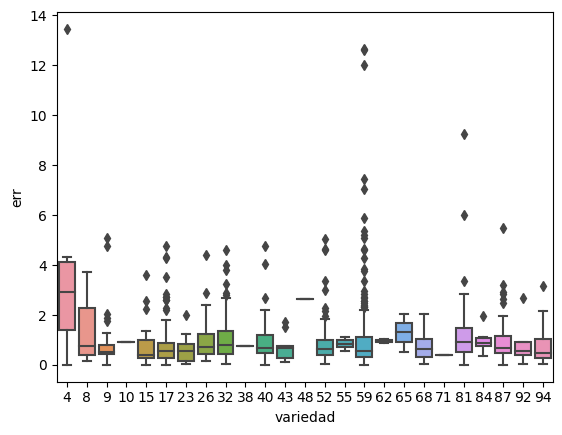

In [984]:
# errors[['produccion','err']].
import seaborn as sns

# sns.jointplot(
#     errors,
#     x=light_cols[1],
#     y='err'
# )
# data[data['id_finca']==95678]

sns.boxplot(
    errors,
    y='err',
    x='variedad'
)


In [791]:
wine_data[wine_data['variedad']==59]

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
9,14,43323,142,14,659.097938,59,1,0,1,NaN,34880.0
12,14,5696,919,14,655.000000,59,1,0,1,NaN,21907.6
19,14,4024,919,14,655.000000,59,2,0,1,NaN,13731.2
23,14,48410,919,14,655.000000,59,1,0,1,NaN,2380.0
25,14,39664,919,14,655.000000,59,1,0,1,NaN,1940.0
...,...,...,...,...,...,...,...,...,...,...,...
9582,22,96832,473,10,465.000000,59,2,0,1,0.4201,NaN
9583,22,83256,473,10,465.000000,59,2,0,1,2.2643,NaN
9584,22,53298,473,10,465.000000,59,2,0,1,2.2158,NaN
9589,22,49636,473,10,465.000000,59,2,0,1,20.8122,NaN


In [496]:
from sklearn.model_selection import cross_validate, GridSearchCV


params = {'max_depth': [2, 3, 6],
          'learning_rate': [0.005, 0.01, 0.03],
          'iterations': [1000, 1500, 2000]
          }


model = GridSearchCV(
    cb.CatBoostRegressor(cat_features=cat_cols, verbose=0, iterations=300),
    param_grid=params
)

model.fit(X_train, y_train)

cross_validate(
    model.best_estimator_,
    X,
    y,
    return_train_score=True
)


{'fit_time': array([1.53612113, 1.5746572 , 1.51042795, 1.72306299, 1.71075678]),
 'score_time': array([0.00911498, 0.00398493, 0.00682068, 0.00318074, 0.0034523 ]),
 'test_score': array([0.5529047 , 0.64864022, 0.59317714, 0.65336972, 0.6250333 ]),
 'train_score': array([0.88088151, 0.8849376 , 0.87320716, 0.88672481, 0.88963846])}

In [497]:
y_pred =  model.best_estimator_.fit(X_train, y_train).predict(X_test)
score_preds(y_test, y_pred)

{'mape': 1.7767825195880502, 'rmse': 1.7159997384973626}

In [517]:
params = {'xgbregressor__max_depth': [2, 3, 6],
          'xgbregressor__learning_rate': [0.005, 0.01, 0.03],
          'xgbregressor__n_estimators': [1000, 1500, 2000],
          'xgbregressor__colsample_bytree': [0.3, 0.7, 0.9]}

estimator = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), cat_cols),
        # (make_pipeline(StandardScaler(), PCA(n_components=7)), meteo_cols+eto_cols),
        # (StandardScaler(), num_cols),
        remainder='passthrough'

    ),
    xgb.XGBRegressor(random_state=seed)
)

model = GridSearchCV(
    estimator,
    param_grid=params, verbose=1, n_jobs=-1)

model.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['id_zona',
                                                                          'variedad',
                                                                          'modo'])])),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     earl...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__colsample_bytree': [0.3, 0.7, 0.9],
                         'xgbregressor__learning_rate': [0.005, 0.01, 0.03],
                         'xgbregressor__max_depth': [2, 3, 6],
                         'xgbregressor__n_estimators': [1000, 1500, 2000]},
             verbose=1)

In [518]:
model.best_params_

{'xgbregressor__colsample_bytree': 0.9,
 'xgbregressor__learning_rate': 0.01,
 'xgbregressor__max_depth': 2,
 'xgbregressor__n_estimators': 2000}

In [519]:
cross_validate(
    model.best_estimator_,
    X,
    y,
    return_train_score=True
)

{'fit_time': array([3.51146388, 3.47982597, 3.48321986, 3.46760607, 3.49442291]),
 'score_time': array([0.00414419, 0.00394392, 0.00386214, 0.00369191, 0.00471807]),
 'test_score': array([0.57755743, 0.60458747, 0.65938483, 0.64163208, 0.63022235]),
 'train_score': array([0.78274987, 0.76362073, 0.75682196, 0.76697514, 0.76360802])}

In [520]:
y_pred = model.best_estimator_.fit(X_train, y_train).predict(X_test)
score_preds(y_test, y_pred)

{'mape': 0.8890380517872596, 'rmse': 1.4924485088369064}

<Axes: >

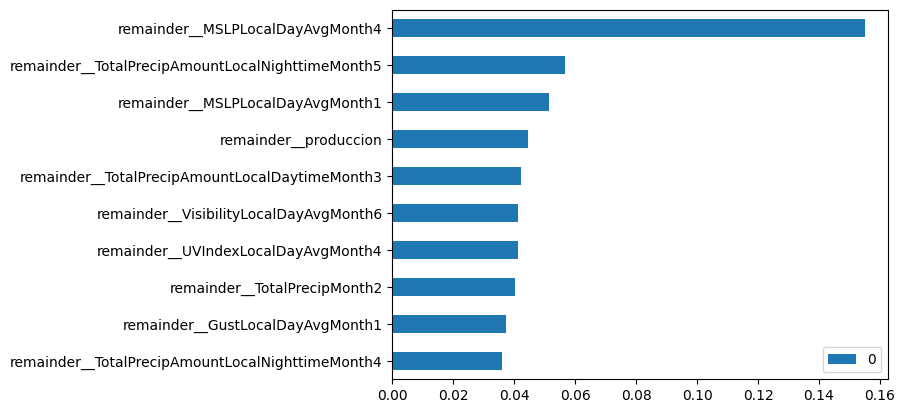

In [521]:
# model.best_estimator_.feature_importances_
fno = model.best_estimator_[:-1].get_feature_names_out()
pd.DataFrame(model.best_estimator_[-1].feature_importances_,
             index=fno).sort_values(0)[-10:].plot(kind='barh')

In [526]:
errors = create_errors_dataframe(X_test, y_test, y_pred)
errors.groupby('variedad').agg(
    mean_err=('err','mean'), 
    count_var=('err','count'),
    max_err=('err','max')
    ).sort_values('mean_err',ascending=False)

,mean_err,count_var,max_err
variedad,,,
62,4.719193,2,5.148483
4,3.112009,6,10.974283
48,2.564278,1,2.564278
8,1.368222,5,3.351896
81,1.087445,64,9.253529
59,1.053909,255,12.736314
52,0.972897,69,5.939235
32,0.908866,107,4.317445
26,0.866427,32,4.601790


In [532]:
model_surface = model.best_estimator_.fit(X, y)


## Modelo Produccion + Weather

In [621]:
# usamos desde 15 en adelante
data_prod = data[data['campana'] > 14].copy()

data_prod_full = data_prod.merge(
    meteo_data,
    left_on=['id_estacion', 'campana'],
    right_on=['ID_ESTACION', 'year'],
    how='left'
).merge(
    eto_data,
    left_on=['id_estacion', 'campana'],
    right_on=['ID_ESTACION', 'year'],
    how='left'
)

# imputamos superficie.
data_prod_full['superficie_real'] = data_prod_full['superficie'].notnull().astype('category')

X_surface = data_prod_full[data_prod_full['superficie'].isnull()]


pred_surface = model_surface.predict(X_surface)

data_prod_full.loc[data_prod_full['superficie'].isnull(),'superficie'] = pred_surface


In [582]:
# reducimos la cardinalidad de zona y variedad

# data_prod_full.groupby('id_zona')['produccion'].count().sort_values(ascending=False)
# data_prod_full.groupby('variedad')['produccion'].count().sort_values(ascending=False)
# data_prod_full.groupby('id_finca')['produccion'].count().sort_values(ascending=False)



0        753
1        753
2        443
3        443
4        443
        ... 
7373     483
7374     753
7375    2139
7376     306
7377     483
Name: variedad, Length: 7378, dtype: int64

In [625]:

X = data_prod_full.drop(columns=['produccion'])
y = data_prod_full['produccion']
# ahora entrenamos para predecir la produccion de 2021

train_idxs, test_idxs = X[
    (X['campana'] < 21) & 
    (X['campana'] > 17)
    ].index, X[X['campana'] == 21].index

cat_cols = [
    # 'id_finca',
    # 'id_estacion',
    'campana',
    'id_zona',
    'variedad',
    'modo',
    # 'tipo',
    'color',

    'superficie_real'
]
num_cols = [
    'superficie',
    'altitud'
]


X[cat_cols] = X[cat_cols].astype('category')

X_train, X_test, y_train, y_test = X.loc[train_idxs],X.loc[test_idxs], y.loc[train_idxs], y.loc[test_idxs]

print(X_train.shape, X_test.shape)


(3122, 135) (1044, 135)


In [607]:
# count_enc = ce.CountEncoder(min_group_size=10)

# X_train['id_zona'] = count_enc.fit_transform(X_train[['id_zona']].astype('category'))['id_zona']
# X_test['id_zona'] = count_enc.transform(X_test[['id_zona']].astype('category'))['id_zona']

# X_train['variedad'] = count_enc.fit_transform(X_train[['variedad']].astype('category'))['variedad']
# X_test['id_zona'] = count_enc.transform(X_test[['variedad']].astype('category'))['variedad']

# X[cat_cols] = X[cat_cols].astype('category')


In [632]:
# X_test


array([0.81818182, 0.81818182, 0.81818182, ..., 0.90909091, 0.90909091,
       0.90909091])

In [634]:
from sklearn.preprocessing import StandardScaler

model = make_pipeline(
    make_column_transformer(
        (ce.BaseNEncoder(base=3), ['variedad']),
        (ce.TargetEncoder(), cat_cols),
        # (ce.CatBoostEncoder(),cat_cols),
        (ce.QuantileEncoder(), cat_cols),
        # (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        (StandardScaler(), num_cols),

        # (make_pipeline(StandardScaler(), PCA(n_components=7)), meteo_cols+eto_cols),
        # (StandardScaler(), light_cols),
        # (StandardScaler(), gust_cols),
        # (StandardScaler(), temp_cols),
        # (StandardScaler(), wind_cols),
        # (StandardScaler(), mlsp_cols),
        # (make_pipeline(StandardScaler(), PCA(n_components=.95)), precip_cols),
        # (StandardScaler(), snow_cols),
        # (StandardScaler(), hum_cols),
        # (StandardScaler(), meteo_temp_cols),
        remainder='drop'
    ),
    RandomForestRegressor(n_estimators=500, max_features='sqrt',
                          criterion='poisson', random_state=seed)
)

sample_weight = X_train['campana'].astype(int).values/22

y_pred = model.fit(
    X_train, y_train, randomforestregressor__sample_weight=sample_weight).predict(X_test)
errors = create_errors_dataframe(X_test, y_test, y_pred)
score_preds(y_test, y_pred)

{'mape': 4.6372899766831, 'rmse': 5665.408686536406}

In [636]:
errors[errors['id_finca'] == 14843]

data[data['id_finca']==14843]

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
202,14,14843,845,16,647.5,62,2,0,0,NaN,10650.880
1347,15,14843,845,16,647.5,62,2,0,0,NaN,40505.316
2458,16,14843,845,16,647.5,62,2,0,0,NaN,33376.998
3534,17,14843,845,16,647.5,62,2,0,0,NaN,39038.478
3535,17,14843,845,16,647.5,87,2,0,0,NaN,13270.000
4559,18,14843,845,16,647.5,62,2,0,0,NaN,33908.834
4560,18,14843,845,16,647.5,87,2,0,0,NaN,51210.000
4561,18,14843,845,16,647.5,43,2,0,0,NaN,8184.876
5615,19,14843,845,16,647.5,62,2,0,0,NaN,18236.828
5616,19,14843,845,16,647.5,87,2,0,0,NaN,82940.000


In [637]:
X_train[X_train['id_finca']==14843]

,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,...,TotalPrecipMonth4,TotalPrecipMonth5,TotalPrecipMonth6,GustDaySumMonth,UVIndexSummerSum,UVIndexWinterSum,UVIndexSummerAvg,UVIndexWinterAvg,WindSpeedSum,superficie_real
3411,18,14843,845,16,647.5,62,2,0,0,7.115485,...,22.8,33.6,54.0,9.76,2.122581,6.133011,0.707527,2.044337,20.879370,False
3412,18,14843,845,16,647.5,87,2,0,0,8.583978,...,22.8,33.6,54.0,9.76,2.122581,6.133011,0.707527,2.044337,20.879370,False
3413,18,14843,845,16,647.5,43,2,0,0,2.863934,...,22.8,33.6,54.0,9.76,2.122581,6.133011,0.707527,2.044337,20.879370,False
4467,19,14843,845,16,647.5,62,2,0,0,3.685951,...,169.2,7.2,0.0,10.06,2.202650,6.164409,0.734217,2.054803,17.048034,False
4468,19,14843,845,16,647.5,87,2,0,0,8.255381,...,169.2,7.2,0.0,10.06,2.202650,6.164409,0.734217,2.054803,17.048034,False
4469,19,14843,845,16,647.5,43,2,0,0,1.683685,...,169.2,7.2,0.0,10.06,2.202650,6.164409,0.734217,2.054803,17.048034,False
5518,20,14843,845,16,647.5,62,2,0,0,9.670800,...,58.8,26.4,19.2,9.30,2.045495,6.184516,0.681832,2.061505,15.602329,True
5519,20,14843,845,16,647.5,87,2,0,0,6.280000,...,58.8,26.4,19.2,9.30,2.045495,6.184516,0.681832,2.061505,15.602329,True
5520,20,14843,845,16,647.5,43,2,0,0,2.740000,...,58.8,26.4,19.2,9.30,2.045495,6.184516,0.681832,2.061505,15.602329,True


In [562]:
params = {'xgbregressor__max_depth': [2, 3, 6],
          'xgbregressor__learning_rate': [0.005, 0.01, 0.03],
          'xgbregressor__n_estimators': [1000, 1500, 2000],
          'xgbregressor__colsample_bytree': [0.3, 0.7, 0.9]}

estimator = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), cat_cols),
        remainder='passthrough'

    ),
    xgb.XGBRegressor(random_state=seed)
)

model = GridSearchCV(
    estimator,
    param_grid=params, verbose=1, n_jobs=-1)

model.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

In [ ]:
model.best_params_

In [ ]:
y_pred = model.best_estimator_.fit(X_train, y_train).predict(X_test)
score_preds(y_test, y_pred)

In [551]:
# params = {'max_depth': [2, 3, 6],
#           'learning_rate': [0.005, 0.01, 0.03],
#           'iterations': [1000, 1500, 2000]
#           }


# model = GridSearchCV(
#     cb.CatBoostRegressor(cat_features=cat_cols, verbose=0, iterations=300),
#     param_grid=params
# )

# model.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x176ebd3d0>,
             param_grid={'iterations': [1000, 1500, 2000],
                         'learning_rate': [0.005, 0.01, 0.03],
                         'max_depth': [2, 3, 6]})

In [555]:
# model.best_params_
# {'iterations': 1000, 'learning_rate': 0.03, 'max_depth': 6}


{'iterations': 1000, 'learning_rate': 0.03, 'max_depth': 6}

In [554]:
# y_pred = model.best_estimator_.fit(X_train, y_train).predict(X_test)
# score_preds(y_test, y_pred)

{'mape': 3.644645452551367, 'rmse': 6558.616427351511}

In [558]:
errors = create_errors_dataframe(X_test, y_test,y_pred)
errors.groupby('variedad').agg(
    mean_err=('err','mean'), 
    count_var=('err','count'),
    max_err=('err','max')
    ).sort_values('mean_err',ascending=False)

,mean_err,count_var,max_err
variedad,,,
62,17424.710462,2,32360.139394
48,10629.422522,1,10629.422522
10,9568.661715,1,9568.661715
8,8898.424676,5,21525.753977
81,5502.995119,64,38129.544978
32,5150.944275,117,38671.078486
87,5064.833890,54,43167.145067
94,4082.945457,29,22991.701045
43,4021.356075,9,10871.222250


In [559]:
errors


,campana,id_zona,variedad,modo,color,superficie,altitud,y_true,y_pred,err
7261,21,50,87,2,0,4.9169,567.5,71550.000,28382.854933,43167.145067
6419,21,964,17,2,1,10.1482,500.0,101750.000,62912.204246,38837.795754
6498,21,506,32,2,1,12.8460,610.0,124620.262,85949.183514,38671.078486
6501,21,506,81,2,1,7.9000,610.0,88416.125,50286.580022,38129.544978
6918,21,144,17,1,1,9.5200,620.0,65057.020,27698.779455,37358.240545
...,...,...,...,...,...,...,...,...,...,...
6873,21,737,9,2,0,5.0129,630.0,18230.000,18220.186582,9.813418
6932,21,412,59,2,1,7.7200,605.0,32526.372,32517.164364,9.207636
7132,21,134,59,1,1,0.3092,460.0,721.248,713.553672,7.694328
6969,21,254,17,1,1,0.2711,665.0,319.200,316.331708,2.868292


In [ ]:
# cross_validate(
#     model.best_estimator_,
#     X,
#     y,
#     return_train_score=True
# )
